In [1]:
'''Classification model - Logistic Regression'''

'''Import all necessary library files'''

from collections import Counter
import glob
import hashlib
import io
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import string
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cross_validation import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
import pandas as pd
%matplotlib inline
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import metacritic
import pickle
import pandas as pd
import shutil

In [2]:
'''Place the reviews.txt file in the working directory and then run all the modules below'''
df = pd.read_csv("reviews.txt",sep='\t')
df.head()

,﻿Review,Sentiment
0,That such intelligence could be contained in a...,100
1,Shines with a kind of inspired madness.,100
2,Here is the most passionate and tender love st...,100
3,"One of the greatest of all American films, but...",100
4,A remarkable film.,100


In [3]:
df.tail()

,﻿Review,Sentiment
44004,The lack of imagination in Stargate is distres...,25
44005,"Oz the Great and Powerful is an oppressive, bl...",25
44006,"It is a grand-looking, grandly empty pageant.",25
44007,There’s exactly one good scene in all of The H...,25
44008,Man on a Ledge just made me think of an old Va...,25


**Data split into positive and negative:**

We split our dataset by considering the reviews with scores above 65 to be Positive and those ones that are below 65 to be considered as negative and store them into two separate dataframes.

In [4]:
#split positive and negative reviews based on scores 
pos = df[df.Sentiment > 65]
neg = df[df.Sentiment < 65]
pos.describe()

,Sentiment
count,21027.000000
mean,81.959623
std,9.922689
min,67.000000
25%,75.000000
50%,80.000000
75%,90.000000
max,100.000000


In [5]:
neg.describe()

,Sentiment
count,22843.000000
mean,44.681434
std,15.531329
min,0.000000
25%,38.000000
50%,50.000000
75%,60.000000
max,63.000000


In [6]:
'''Drop the Sentiment column from the dataframe'''
pos = pos.drop('Sentiment', 1)
neg = neg.drop('Sentiment',1)

In [7]:
'''Create a folder called data-MNB in your working directory along with pos and neg sub folders present
in both train and test folders. After creation navigate using cd command to the pos sub-folder under train. '''

cd C:\Users\Praveen\Desktop\CS-579-Project\data-LR\train\pos

C:\Users\Praveen\Desktop\CS-579-Project\data-LR\train\pos


In [9]:
'''Storing each review from the positive dataframe into the positive sub-folder'''
i=1
for index, row in pos.iterrows():
    if i > len(pos):
        break
    else:
        f = open(str(i)+'.txt', 'w')
        f.write(row[0])
        f.close()
        i+=1

In [10]:
'''Navigate using cd command to the neg sub-folder under train'''
cd C:\Users\Praveen\Desktop\CS-579-Project\data-LR\train\neg

C:\Users\Praveen\Desktop\CS-579-Project\data-LR\train\neg


In [11]:
'''Storing each review from the negative dataframe into the negative sub-folder'''
i=1
for index, row in neg.iterrows():
    if i > len(neg):
        break
    else:
        f = open(str(i)+'.txt', 'w')
        f.write(row[0])
        f.close()
        i+=1

In [14]:
'''Back up again to your working directory using triple cd '''
cd ..

C:\Users\Praveen\Desktop\CS-579-Project


In [15]:
'''Setting path and listing out the sub-directories in the specified path'''
path = 'data-LR'
print('subdirectories are:' + str(os.listdir(path)))

subdirectories are:['test', 'train']


In [16]:
def get_files(path):
    """ Return a list of file names in this directory that end in .txt 
    The list should be sorted alphabetically by file name.
    Params:
        path....a directory containing .txt review files.
    Returns:
        a list of .txt file names, sorted alphabetically.
    """
    files = os.listdir(path)
    res=[]
    for f in files:
        if f.endswith('.txt'):
                res.append((path + os.sep + f))
    return sorted(res)

In [17]:
'''Print the length of positive and negative files before splitting test data'''
pos_train = get_files(path + os.sep + 'train' + os.sep + 'pos')
neg_train = get_files(path + os.sep + 'train' + os.sep + 'neg')
all_train = pos_train + neg_train
print len(pos_train)
print len(neg_train)

21027
22843


In [18]:
'''Split testing data from the whole dataset'''
for i in range(18001,len(pos_train)+1): 
    shutil.move("data-LR/train/pos/" + str(i)+'.txt', "data-LR/test/pos/" + str(i)+'.txt')
for i in range(18001,len(neg_train)+1):
    shutil.move("data-LR/train/neg/" + str(i)+'.txt', "data-LR/test/neg/" + str(i)+'.txt')

In [19]:
'''Print the length of positive and negative training files after splitting test data'''
pos_train_files = get_files(path + os.sep + 'train' + os.sep + 'pos')
neg_train_files = get_files(path + os.sep + 'train' + os.sep + 'neg')
all_train_files = pos_train_files + neg_train_files
print len(pos_train_files)
print len(neg_train_files)

18000
18000


In [20]:
print('found %d positive and %d negative training files' %
      (len(pos_train_files), len(neg_train_files)))
print('first positive file: %s' % pos_train_files[0])
print('first negative file: %s' % neg_train_files[0])

found 18000 positive and 18000 negative training files
first positive file: data-LR\train\pos\1.txt
first negative file: data-LR\train\neg\1.txt


In [21]:
def get_true_labels(file_names):
    """Return a *numpy array* of ints for the true sentiment labels of each file.
    1 means positive, 0 means negative. Use the name of the file to determine
    the true label.
    Params:
        file_names....a list of .txt file paths, e.g., data/train/pos/10057_9.txt
    Returns:
        a numpy array of 1 or 0 values corresponding to each element
        of file_names, where 1 indicates a positive review, and 0
        indicates a negative review.
    """
    x=np.ones((len(file_names[:(len(file_names)/2)]),), dtype=np.int)
    y=np.zeros((len(file_names[(len(file_names)/2):]),), dtype=np.int)
    z=np.concatenate([x, y])
    return z

In [22]:
labels = get_true_labels(all_train_files)
print('first 3 and last 3 labels are: %s' % str(labels[[1,2,3,-3,-2,-1]]))

first 3 and last 3 labels are: [1 1 1 0 0 0]


In [23]:
def file2string(filename):
    return io.open(filename,encoding='utf8').readlines()[0]
   
file2string(pos_train_files[10])

u"Coppola brilliantly conjures the young queen's insular world, in which she was both isolated and claustrophobically scrutinized."

In [24]:
def tokenize(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    x=re.findall(r'\w+',text.lower())
    return x

In [25]:
def do_vectorize(filenames, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    vectorizer = CountVectorizer(input='filename',tokenizer=tokenizer_fn,min_df=min_df,
                 max_df=max_df, binary=binary, ngram_range=ngram_range,dtype=int)
    dtm = vectorizer.fit_transform(filenames)
    
    return (dtm,vectorizer)
    
matrix,vec = do_vectorize(all_train_files)

print ('matrix represents %d documents with %d features' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[0].nonzero()[1]))))

matrix represents 36000 documents with 37810 features
first doc has terms:
[398, 1485, 2932, 6992, 7317, 10948, 13300, 16539, 17144, 17504, 18345, 21311, 21890, 23100, 30245, 30854, 30981, 32375, 33485]


In [26]:
# Do not modify. This is to randomize the order of the documents, but
# in a way that is consistent across platforms.
# You should run this block once to get the shuffled data.
def repeatable_random(seed):
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y, filenames):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices], np.array(filenames)[indices]

X, y, filenames = repeatable_shuffle(matrix, labels, all_train_files)

print('first shuffled document %s has label %d and terms: %s' % 
      (filenames[0], y[0], sorted(X[0].nonzero()[1])))

first shuffled document data-LR\train\pos\10103.txt has label 1 and terms: [1442, 1697, 1911, 2049, 2651, 2932, 3106, 5917, 9820, 10213, 10502, 10577, 12545, 12805, 15577, 15968, 17565, 19152, 19277, 21918, 22362, 22628, 29313, 29580, 30008, 30854, 33901]


**Logistic Regression**

Logistic regression fits a logistic model to data and makes predictions about the probability of an event (between 0 and 1) in our case its going to be either positive or negative. It is a linear model for classification rather than regression. It is also known as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. The goal of this model is to learn from the training data so that you can predict the label of new examples that we haven't seen before and don't know the label of.

In [27]:
# Do not modify. This creates a LogsticRegression object, which
# you will use in the do_cross_validation method below.
def get_clf():
    return LogisticRegression(random_state=42)

In [28]:
#Logistic Regression
def do_cross_validation_LR(X, y, n_folds=8, verbose=False):
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    cv = KFold(len(y), n_folds)
    acc = []
    n=0
    for train_idx, test_idx in cv:
        clf = get_clf()
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        accuracy = accuracy_score(y[test_idx], predicted)
        acc.append(accuracy)
        if verbose:
            print 'fold %d accuracy=%.4f' % (n,accuracy)
        n=n+1
    avg = np.mean(acc)
    return avg
    
print('average cross validation accuracy using logistic regression classifier=%.4f' %
      do_cross_validation_LR(X, y, verbose=True))

fold 0 accuracy=0.7400
fold 1 accuracy=0.7409
fold 2 accuracy=0.7584
fold 3 accuracy=0.7391
fold 4 accuracy=0.7418
fold 5 accuracy=0.7436
fold 6 accuracy=0.7453
fold 7 accuracy=0.7416
average cross validation accuracy using logistic regression classifier=0.7438


In [29]:
def do_expt_LR(filenames, y, tokenizer_fn=tokenize,
            min_df=1, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=8):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        filenames.......list of review file names
        y...............the true sentiment labels for each file
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
        n_folds.........The number of cross-validation folds to use.
    Returns:
        the average cross validation testing accuracy.
    """
    m,vec = do_vectorize(filenames,binary=binary,tokenizer_fn=tokenizer_fn,min_df=min_df,max_df=max_df)
    res=(do_cross_validation_LR(m,y,n_folds=n_folds))
    #avg = np.mean(res)

    return res

In [30]:
print('accuracy using Logistic regression with default settings: %.4g' % do_expt_LR(filenames, y))

accuracy using Logistic regression with default settings: 0.7439


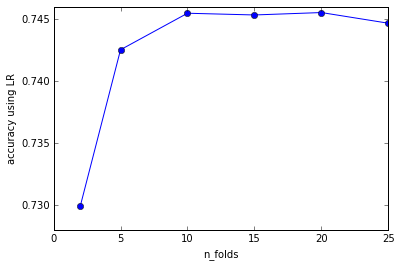

[0.72994444444444451,
 0.74252777777777779,
 0.7454722222222222,
 0.74533333333333329,
 0.74552777777777768,
 0.7446666666666667]

In [31]:
def compare_n_folds(filenames, y):
    """
    Vary the setting of n_folds parameter in the do_expt 
    function to be in [2,5,10,15,20,25]. For each setting, call do_expt and 
    store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per fold.
    """
    fold=[2,5,10,15,20,25]
    avg_acc_LR=[]
    for f in fold:
        avg_acc_LR.append(do_expt_LR(filenames,y,n_folds=f))
        
    plt.xlabel('n_folds')
    plt.ylabel('accuracy using LR')
    plt.plot(fold,avg_acc_LR,'bo-')
    plt.show()
    
    return avg_acc_LR
    
compare_n_folds(filenames, y)

**Graph inference**

When number of folds increases for a fixed amount of data, number of data within each fold decreases. Hence, less data is available for testing. Also, more data is available for training purposes. Therefore, effect of increasing number of folds on accuracy becomes twofold. It trains the model more and tests the model with less data per fold. Hence, accuracy increases.

In [32]:
def compare_binary(filenames, y):
    """
    How does the binary parameter affect results? 
    Call do_expt twice, once with binary=True, and once with binary=False.
    Return the average accuracies for each. Use the default parameters for the
    remaining arguments in do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies. The first entry
        is for binary=True, the second is for binary=False.
    """
    avg_LR=[]
    avg_LR.append(do_expt_LR(filenames,y,binary=True))
    avg_LR.append(do_expt_LR(filenames,y,binary=False))
    return avg_LR

compare_binary(filenames, y)

[0.74386111111111108, 0.74344444444444435]

In [33]:
def tokenize_with_punct(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is kept as separate tokens.
    Note that underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    y=re.sub(r'[\n\r\x85]', ' ', text.lower())
    x=re.findall(r"[\w]+|[\S]", y.lower())
    return x

In [34]:
def tokenize_with_not(text):
    """Does the same thing as tokenize_with_punct, with the following difference:
    whenever the term 'not' appears, change the two subsequent tokens to have the prefix
    'not_' prior to the token. See the example below. You may call 
    tokenize_with_punct as a subroutine.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    res= []
    
    k=0
    for token in tokenize_with_punct(text):
        if token == 'not':
            k=2
            res.append(token)
        else:
            if k>0:
                join = 'not_' + token
                res.append(join)
                k = k-1
            else:
                res.append(token)

    return res

In [35]:
def tokenizer_expt(all_train_files, y):
    """
    How does the tokenizer affect results? 
    Call do_expt three times, using three different tokenizers:
    1- tokenize
    2- tokenize_with_punct
    3- tokenize_with_not
    Return the average cross-validation accuracy for each approach,
    in the above order. Use the default parameters for all other 
    arguments to do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies for each tokenizer.
    """
    avg_LR=[]
    avg_LR.append(do_expt_LR(all_train_files,y,tokenizer_fn=tokenize))
    avg_LR.append(do_expt_LR(all_train_files,y,tokenizer_fn=tokenize_with_punct))
    avg_LR.append(do_expt_LR(all_train_files,y,tokenizer_fn=tokenize_with_not))
    return avg_LR

tokenizer_expt(filenames, y)

[0.74386111111111108, 0.7436666666666667, 0.74622222222222223]

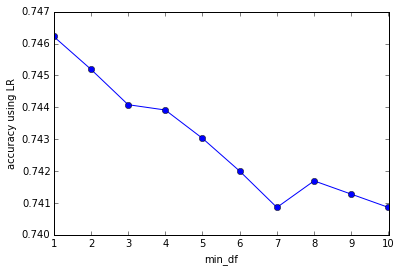

[0.74622222222222223,
 0.74519444444444449,
 0.74408333333333332,
 0.74391666666666667,
 0.74302777777777784,
 0.74199999999999999,
 0.74086111111111108,
 0.74169444444444443,
 0.7412777777777777,
 0.74086111111111108]

In [36]:
def min_df_expt(filenames, y):
    """
    Vary the setting of min_df parameter in the do_expt 
    function to be ints in the range (1,10) (inclusive). For each setting,
    call do_expt and store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function, except that the tokenizer
    should be tokenize_with_not.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per min_df value.
    """
    avg_LR=[]
    for i in range(1,11):
        avg_LR.append(do_expt_LR(filenames,y,tokenizer_fn=tokenize_with_not,min_df=i,max_df=1., binary=True, ngram_range=(1,1)))
    #plt.plot(avg,color='b')
    plt.xlabel('min_df')
    plt.ylabel('accuracy using LR')
    plt.plot(range(1,11),avg_LR,'bo-')
    plt.show()
    return avg_LR

min_df_expt(filenames, y)

**Decline in accuracy**

The min_df parameter refers particularly to the cut-off value for ignoring terms that have lower document frequency than the mentioned value. Setting a too low value will ignore very rare terms which doesn't count towards sentiment calculation. A bit higher value will ignore sufficient rare terms which will improve accuracy. If the value is high, the model will ignore necessary terms as well and that's why we observe a decline in accuracy in the right hand side of the above graph.

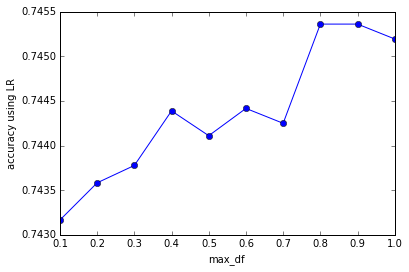

[0.74316666666666675,
 0.74358333333333326,
 0.74377777777777776,
 0.74438888888888888,
 0.74411111111111106,
 0.74441666666666662,
 0.74424999999999997,
 0.74536111111111114,
 0.74536111111111114,
 0.74519444444444449]

In [37]:
def max_df_expt(filenames, y):
    """
    Vary the setting of max_df parameter in the do_expt 
    function to be one of [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.].
    For each setting, call do_expt and store the resulting accuracy.
    Plot the accuracies for each setting. Also return the list of accuracies.
    Use the default value for all other arguments to the do_expt function,
    except that the tokenizer=tokenize_with_not and min_df=2.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per max_df value.
    """
    avg_LR=[]
    max = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
    for i in max:
        avg_LR.append(do_expt_LR(filenames,y,tokenizer_fn=tokenize_with_not,min_df=2,max_df=i, binary=True, ngram_range=(1,1)))
    
    plt.xlabel('max_df')
    plt.ylabel('accuracy using LR')
    plt.plot(max,avg_LR,'bo-')
    plt.show()
    return avg_LR
    
max_df_expt(filenames, y)

In [38]:
X, vec = do_vectorize(filenames, tokenizer_fn=tokenize_with_not,
                      binary=True, min_df=2, max_df=.7)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = get_clf()
clf.fit(X_train, Y_train)
print 'Logistic Regression classifier accuracy for training data:', round(clf.score(X_train, Y_train), 3)
print 'Logistic Regression classifier accuracy for test data:', round(clf.score(X_test, Y_test),3)

Logistic Regression classifier accuracy for training data: 0.938
Logistic Regression classifier accuracy for test data: 0.74


In [39]:
#clf = get_clf()
print type(clf.coef_)
print clf.coef_.shape

<type 'numpy.ndarray'>
(1L, 24221L)


In [40]:
# Here are the first 10 coefficients.
print (clf.coef_[0][:10])

# The features corresponding to them can be found using the vectorizer's get_feature_names method.
print(vec.get_feature_names()[:10])

[-0.1601789  -0.3742802  -0.04094723 -0.01446321 -0.25829122 -0.148396
 -0.1525353   0.35590702 -0.25288177 -0.13078207]
[u'!', u'"', u'#', u'$', u'%', u'&', u"'", u'(', u')', u'*']


In [41]:
#Using the Logistic regression classifier
def get_top_coefficients(clf, vec, n=10):
    """ Get the top n coefficients for each class (positive/negative).
    Params:
        clf...a LogisticRegression object that has already been fit to data.
        vec...a CountVectorizer
        n.....the number of features to print per class.
    Returns:
        Two lists of tuples. The first list containts the top terms for the positive
        class. Each entry is a tuple of (string, float) pairs, where
        string is the feature name and float is the coefficient.
        The second list is the same but for the negative class.
        In each list, entries should be sorted in descending order of 
        absolute value."""
    pos=[]
    neg=[]
    for k,v in enumerate(vec.get_feature_names()):
        if clf.coef_[0][k] > 0.:
            pos.append((v,clf.coef_[0][k]))
        else:
            neg.append((v,clf.coef_[0][k]))
            
    positive = sorted(pos,key=lambda x: x[1],reverse=True)
    p1=positive[:n]
    negative = sorted(neg,key=lambda x: x[1])
    n1=negative[:n]
    return (p1,n1)

pos_coef, neg_coef = get_top_coefficients(clf, vec, n=5)
print('top positive coefs: %s' % str(pos_coef))
print('top negative coefs: %s' % str(neg_coef))

top positive coefs: [(u'exhilarating', 1.8806495874506894), (u'observant', 1.7936650345103218), (u'dazzling', 1.7402614379596228), (u'remarkable', 1.7026976851513291), (u'hilarious', 1.6942880452427078)]
top negative coefs: [(u'worst', -2.1926024982375738), (u'dull', -2.0974927865955979), (u'pointless', -2.0165020483092362), (u'unfunny', -1.9745497771120379), (u'muddled', -1.9485014548289517)]


In [42]:
# Do not modify.
def index_of_term(vec, term):
    """ This returns the column index corresponding to this term."""
    return vec.get_feature_names().index(term)

index_of_term(vec, 'movie')

13769

In [46]:
features = vec.get_feature_names()
eyematrix = np.eye(len(features))
# compute per-word probability by running I-matrix through our classifier
perword_proba = clf.predict_proba(eyematrix)

In [47]:
perword_neg, perword_pos = zip(*perword_proba)
# make dict with negative and  positive probs plus actual word
perword_dict = {'word':features, 'prob negative':perword_neg, 'prob positive':perword_pos}
# convert to df for easier processing
perword_df = pd.DataFrame(data = perword_dict)

# sort each in descending order, grab top 10, print
print 'Top 10 positive Predictor Words according to Logistic Regression classifier: \n', perword_df.sort(columns='prob positive', ascending=False).iloc[1:10,[2,0]],'\n'

print 'Top 10 negative Predictor Words according to Logistic Regression classifier: \n', perword_df.sort(columns='prob negative', ascending=False).iloc[1:10,[2,1]]

Top 10 positive Predictor Words according to Logistic Regression classifier: 
                word  prob negative
14980      observant       0.178454
5222        dazzling       0.186419
17739     remarkable       0.192183
9862       hilarious       0.193492
22629  unforgettable       0.197206
6483        dynamite       0.203187
2744     brilliantly       0.206703
12925      masterful       0.206972
12930    masterpiece       0.210218 

Top 10 negative Predictor Words according to Logistic Regression classifier: 
               word  prob positive
6405           dull       0.085936
16331     pointless       0.092514
22642       unfunny       0.096097
13795       muddled       0.098384
22796  unsatisfying       0.103929
23846       witless       0.109129
7561          fails       0.115985
13215          mess       0.118060
9548       harmless       0.118065


In [48]:
#calculate testing accuracy again by generating vocabulary on reviews present in the test folder. 
#Here we again use the Logistic regression classifier at first to predict the accuracy on test data.
pos_test_files = get_files(path + os.sep + 'test' + os.sep + 'pos')
neg_test_files = get_files(path + os.sep + 'test' + os.sep + 'neg')
all_test_files = pos_test_files + neg_test_files
# Note that we call .transform, not .fit_transform, since we 
# don't want to learn a new vocabulary.
X_test = vec.transform(all_test_files)
y_test = np.array([1] * len(pos_test_files) + [0] * len(neg_test_files))
print('X_test represents %d documents with %d features' % (X_test.shape[0], X_test.shape[1]))
print('y_test has %d positive and %d negative labels' % (len(np.where(y_test==1)[0]),
                                                          len(np.where(y_test==0)[0])))
print('first testing file is %s' % all_test_files[0])
print('last testing file is %s' % all_test_files[-1])
print('testing accuracy=%.4g' % accuracy_score(y_test, clf.predict(X_test)))

X_test represents 7870 documents with 24221 features
y_test has 3027 positive and 4843 negative labels
first testing file is data-LR\test\pos\18001.txt
last testing file is data-LR\test\neg\22843.txt
testing accuracy=0.7227


In [49]:
def train_after_removing_features(X, y, vec, features_to_remove):
    """
    Set to 0 the columns of X corresponding to the terms in features_to_remove. 
    Then, train a new classifier on X and y and return the result.
    Params:
        X....................the training matrix
        y....................the true labels for each row in X
        features_to_remove...a list of strings (entries in the vocabulary) that
                             should be removed from X
    Returns:
       The classifier fit on the modified X data.
    """
    arr=X.toarray()
    shape = X.get_shape()
    for each in features_to_remove:
        r=0
        res=index_of_term(vec,each)
        while r<shape[0]:
            arr[r][res] = 0
            r=r+1
    clf = get_clf()
    clf.fit(arr, y)
    return clf
    
    
clf = train_after_removing_features(X.copy(), y, vec, ['film'])
print('testing accuracy=%.5g' % accuracy_score(y_test, clf.predict(X_test)))

testing accuracy=0.72503


In [50]:
def get_top_errors(X_test, y_test, filenames, clf, n=10):
    """
    Use clf to predict the labels of the testing data in X_test. 
    We want to find incorrectly predicted documents. Furthermore, we want to look at those 
    where the probability of the incorrect label, according to the classifier, is highest.
    Use the .predict_proba method of the classifier to get the probabilities of
    each class label. Return the n documents that were misclassified, sorted by the
    probability of the incorrect label. The returned value is a list of dicts, defined below.
    Params:
        X_test......the testing matrix
        y_test......the true labels for each testing document
        filenames...the filenames for each testing document
        clf.........a trained LogisticRegression object
        n...........the number of errors to return
    Returns:
        A list of n dicts containing the following key/value pairs:
           index: the index of this document (in the filenames array)
           probas: a numpy array containing the probability of class 0 and 1
           truth: the true label
           predicted: the predicted label
           filename: the path to the file for this document
    """
    
    predict = clf.predict(X_test)
    predict_prob = clf.predict_proba(X_test)
    res=[]

    for i in range(len(predict)):
        if predict[i] != y_test[i]:
            res.append(({'filename':filenames[i],'index':filenames.index(filenames[i]),'predicted':predict[i],
                         'probas':predict_prob[i],'truth':y_test[i]}))
 
    return sorted(res,key=lambda x:abs(max(x['probas'])),reverse=True)[:n]
 
errors = get_top_errors(X_test, y_test, all_test_files, clf)
errors

[{'filename': 'data-LR\\test\\pos\\20994.txt',
  'index': 2993,
  'predicted': 0,
  'probas': array([ 0.99890797,  0.00109203]),
  'truth': 1},
 {'filename': 'data-LR\\test\\neg\\22197.txt',
  'index': 7223,
  'predicted': 1,
  'probas': array([ 0.00124462,  0.99875538]),
  'truth': 0},
 {'filename': 'data-LR\\test\\pos\\20379.txt',
  'index': 2378,
  'predicted': 0,
  'probas': array([ 0.99869523,  0.00130477]),
  'truth': 1},
 {'filename': 'data-LR\\test\\neg\\21555.txt',
  'index': 6581,
  'predicted': 1,
  'probas': array([ 0.0016089,  0.9983911]),
  'truth': 0},
 {'filename': 'data-LR\\test\\pos\\18440.txt',
  'index': 439,
  'predicted': 0,
  'probas': array([ 0.99726171,  0.00273829]),
  'truth': 1},
 {'filename': 'data-LR\\test\\pos\\20006.txt',
  'index': 2005,
  'predicted': 0,
  'probas': array([ 0.99685599,  0.00314401]),
  'truth': 1},
 {'filename': 'data-LR\\test\\pos\\19188.txt',
  'index': 1187,
  'predicted': 0,
  'probas': array([ 0.99602176,  0.00397824]),
  'truth':

In [51]:
# Given a document, find the term in it that is most strongly associated
# with a given class label, according to a trained classifier.
def most_predictive_term_in_doc(instance, clf, class_idx):
    """
    Params:
        instance....one row in the X csr_matrix, corresponding to a document.
        clf.........a trained LogisticRegression classifier
        class_idx...0 or 1. The class for which we should find the most 
                    predictive term in this document.
    Returns:
        The index corresponding to the term that appears in this instance
        and has the highest coefficient for class class_idx.
    """
    x=instance.toarray()
    li=np.array(x).tolist()
    tup=[]
    for i in li:
        for k,v in enumerate(i):
            if v == 1:
                #word_ind.append(k)
                tup.append((k,clf.coef_[0][k]))
    if class_idx == 1:
        res=sorted(tup,key=lambda x: x[1],reverse=True)[0]
    elif class_idx == 0:
        res=sorted(tup,key=lambda x:x[1])[0]
    
    return int(res[0])
                  
neg_idx = most_predictive_term_in_doc(X_test[0], clf, 0)
pos_idx = most_predictive_term_in_doc(X_test[0], clf, 1)
print('for document %s, the term most predictive of class 0 is %s (index=%d)' %
      (all_test_files[0], vec.get_feature_names()[neg_idx], neg_idx))
print('for document %s, the term most predictive of class 1 is %s (index=%d)' %
      (all_test_files[0], vec.get_feature_names()[pos_idx], pos_idx))

for document data-LR\test\pos\18001.txt, the term most predictive of class 0 is treacly (index=22105)
for document data-LR\test\pos\18001.txt, the term most predictive of class 1 is irresistibly (index=11111)


In [52]:
def find_contexts(filename, term, window=5):
    """
    Find all context windows in which this term appears in this file.
    You should use tokenize_with_not to tokenize this file. 
    
    Params:
        filename....the filename for this document.
        term........the term to find
        window......return this many tokens to the left and this many tokens to
                    the right of every occurrence of term in this document
    Returns:
        a list of strings. Each string contains the matched context window.
    """
    f = open(filename, 'r+').read()
    token = tokenize_with_not(f)
    res= []
    
    k=0
    for k,v in enumerate(token):
        #if cmp(v,term) == 0:
        if v == term:
            if k+window < len(token):
                res.append((' '.join(token[(k-window):(k+window+1)]))) 
            elif k+window == len(token):
                res.append((' '.join(token[(k-window):])))   
            else:
                res.append((' '.join(token[(k-window):])))
                
    y = [unicode(i) for i in res]     
    return res

# Here are some sample outputs on the first test document:
print('"love" context with window 3: %s' % find_contexts(all_test_files[0], 'love', 3))
print('"touch" context with window 5: %s' % find_contexts(all_test_files[12], 'touch', 5))
#print('"best" context: %s' % find_contexts(all_test_files[50], 'best'))
#print('"a" contexts: %s' % find_contexts(all_test_files[200], 'a'))

"love" context with window 3: ['drama about doomed love . the film']
"touch" context with window 5: ['film with a deft comedic touch and a trio of charming']
